In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class BPR(nn.Module):
    def __init__(self):
        super(BPR, self).__init__()
        self.W = None             # user matrix
        self.H = None             # item matrix
        
        self.uid = None
        self.iid = None
        
        # 用户u对应他访问过的所有items集合
        self.train_user_items = None
        self.test_user_items = None
        
        # (u, i, rating) dataset
        self.train = None
        self.test = None
        
        # log
        self.loss2=[]
        self.prec2=[]
        self.recall2=[]
        self.ndcg2=[]
        
    def _split(self, df, ratio):
        train = pd.DataFrame(columns = df.columns, dtype=int)
        test = pd.DataFrame(columns = df.columns, dtype=int)
        for i in self.uid:
            train_1, test_1 = train_test_split(df[df.iloc[:, 0] == i], train_size = ratio, shuffle = True, random_state = 5)
            train = pd.concat([train, train_1])
            test = pd.concat([test, test_1])
        return train, test    
    
    def preprocess(self, df, train_size=0.8):
        df = df.rename(columns = {df.columns[0]: 'ori_uid', df.columns[1]: 'ori_iid', df.columns[2]: 'rating'})
        df = df.groupby('ori_uid').filter(lambda x: x['ori_uid'].count()>=10)
        uid_map = pd.DataFrame({"ori_uid": np.asarray(list(set(df.iloc[:,0].values)))})
        uid_map["serial_uid"] = uid_map.index
        iid_map = pd.DataFrame({"ori_iid": np.asarray(list(set(df.iloc[:,1].values)))})
        iid_map["serial_iid"] = iid_map.index
        
        self.uid = uid_map["serial_uid"].values
        self.iid = iid_map["serial_iid"].values
        
        df = df.merge(uid_map, left_on = 'ori_uid', right_on = 'ori_uid', how="left")
        df = df.merge(iid_map, left_on = 'ori_iid', right_on = 'ori_iid', how="left")
        df = df[['serial_uid', 'serial_iid', 'rating']]
        
        train, test = self._split(df, train_size)
        
        self.train_user_items = train.groupby(train.columns[0])[train.columns[1]].apply(lambda x: list(x)).to_list()
        self.test_user_items = test.groupby(test.columns[0])[test.columns[1]].apply(lambda x: list(x)).to_list()
        
        self.train = train
        self.test = test
    
    def generate_train_batch(self, batch, sets,ite=10):
        train = []
        for b in range(batch):
            u = self.uid[np.random.randint(0, len(self.uid))]
            i = sets[u][np.random.randint(0, len(sets[u]))]
            lis = [u,i]
            for a in range(ite):
                j = self.iid[np.random.randint(0, len(self.iid))]
                while j in sets[u]:
                    j = self.iid[np.random.randint(0, len(self.iid))]
                lis.append(j)
            train.append(lis)
        return np.asarray(train) 
    
    def fit(self, k, stepsize=0.05, max_iter=10, batch=10000, n=10,ite=10):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.loss2=[]
        self.prec2=[]
        self.recall2=[]
        self.ndcg2=[]
        
        self.W = nn.Parameter(torch.rand(len(self.uid), k).to(device) * 0.01)    # 初始化 W，H
        self.H = nn.Parameter(torch.rand(len(self.iid), k).to(device) * 0.01)  
 
        optimizer = optim.Adam([self.W, self.H], lr=stepsize)     # 主模型优化器
        for x in range(max_iter):
            #取训练批次：uij三元组
            uij = self.generate_train_batch(batch, self.train_user_items,ite)
            
            u = uij[:, 0]
            i = uij[:, 1]
            
            u_emb = self.W[u]
            i_emb = self.H[i]
            
            
            j_embs = torch.zeros_like(i_emb) 
            
            for i in range(2, 2 + ite):  
                j = uij[:, i]  
                j_emb = self.H[j]  
                j_embs+=torch.exp(u_emb*j_emb)
            j_embs=j_embs/ite
            
            
            optimizer.zero_grad()
            loss = torch.sum((torch.sum(-u_emb * i_emb +torch.log(torch.exp(u_emb * i_emb) +j_embs+1e-8))+1e-8))
            loss.backward()
            optimizer.step()
            
            print(f"Train | {x+1}/{max_iter}, BPR loss: {loss.item() / batch}")
            self.loss2.append(loss.item() / batch)
            rec, pre, ndcg = self.performance(n)
            self.recall2.append(rec)
            self.prec2.append(pre)
            self.ndcg2.append(ndcg)
            print(f'Valid | {x+1}/{max_iter}, Pre@{n}: {pre}, Recl@{n}: {rec}, NDCG@{n}: {ndcg}')
            print('---------------------------------------------------')
    
    def _predict(self, uid, items, n):
        scores = torch.mv(self.H[items], self.W[uid])
        if n > scores.shape[0]: 
            n = scores.shape[0]
        top_N_val, top_N_idx = torch.topk(scores, k=n)
        return list(zip(items[top_N_idx.cpu()], top_N_val.cpu()))

    def NDCG(self, uid, n):         # 用模型排序+真实分数计算 DCG, 重排后计算 iDCG
        test_user = self.test[self.test.iloc[:, 0] == uid]
        rating = self._predict(uid, test_user.iloc[:, 1].values, n)
        irating =sorted(test_user.iloc[:, 2].values, reverse=True)
        dcg = 0
        idcg = 0
        if n > len(irating): n = len(irating)  
        for i in range(n):
            r = test_user[test_user.iloc[:, 1]==rating[i][0]].iloc[0, 2]
            dcg += 1.0 * (2**r - 1) / math.log(i + 2, 2)
            idcg += 1.0 * (2**irating[i] - 1) / math.log(i + 2, 2)
        return dcg / idcg

    def performance(self, n):      # Output recall@n, precision@n, NDCG@n
        hit = 0
        n_recall = 0
        n_precision = 0
        ndcg = 0
        
        for i in self.uid:
            # Items that User i hasn't tried in training set
            unknown_items = np.setdiff1d(self.iid, self.train_user_items[i])
            # Items that User i actually tried in testing set
            known_items = self.test_user_items[i]
            
            #目标：预测 unknown items 中的top_N，若击中test中的items，则为有效预测
            ru = self._predict(i, unknown_items, n)
            
            hit += sum(1 for item, pui in ru if item in known_items)
            n_recall += len(known_items)
            n_precision += n
            ndcg += self.NDCG(i, n)
            
        recall = hit / (1.0 * n_recall)
        precision = hit / (1.0 * n_precision)
        ndcg /= len(self.uid)
        return recall, precision, ndcg
    
    def arrays(self):
        return self.loss2,self.prec2,self.recall2,self.ndcg2


In [3]:
df1 = pd.read_csv("./ml-100k/u.data", sep="\t", names=['user id', 'item id', 'rating', 'timestamp'])
df2 = pd.read_csv("./ml-1m/ratings.dat", sep="::", names=['user id', 'item id', 'rating', 'timestamp'], engine='python')

### 100K

In [4]:
model1 = BPR()
model1.preprocess(df1)

In [5]:
log = []
for i in range(9):
    model1.fit(k = 50, max_iter = 100,ite=i+2,stepsize=0.05)
    loss_2,prec_2,recall_2,ndcg_2=model1.arrays()
    log.append((loss_2, prec_2, recall_2, ndcg_2))

Train | 1/100, BPR loss: 34.6573625
Valid | 1/100, Pre@10: 0.019088016967126194, Recl@10: 0.008831755065992836, NDCG@10: 0.6911924632522576
---------------------------------------------------
Train | 2/100, BPR loss: 34.652665625
Valid | 2/100, Pre@10: 0.11346765641569459, Recl@10: 0.052499877336735196, NDCG@10: 0.7330713260767087
---------------------------------------------------
Train | 3/100, BPR loss: 34.578459375
Valid | 3/100, Pre@10: 0.1241781548250265, Recl@10: 0.05745547323487562, NDCG@10: 0.7381291493487396
---------------------------------------------------
Train | 4/100, BPR loss: 34.429571875
Valid | 4/100, Pre@10: 0.12841993637327678, Recl@10: 0.059418085471762916, NDCG@10: 0.739022369446621
---------------------------------------------------
Train | 5/100, BPR loss: 34.192765625
Valid | 5/100, Pre@10: 0.12990455991516436, Recl@10: 0.06010499975467347, NDCG@10: 0.7400447041899815
---------------------------------------------------
Train | 6/100, BPR loss: 33.8581125
Vali

Train | 44/100, BPR loss: 16.8788984375
Valid | 44/100, Pre@10: 0.16850477200424177, Recl@10: 0.07796477111034787, NDCG@10: 0.7401927292220434
---------------------------------------------------
Train | 45/100, BPR loss: 16.758684375
Valid | 45/100, Pre@10: 0.16861081654294804, Recl@10: 0.07801383641627005, NDCG@10: 0.7399445816509715
---------------------------------------------------
Train | 46/100, BPR loss: 17.015740625
Valid | 46/100, Pre@10: 0.168186638388123, Recl@10: 0.07781757519258133, NDCG@10: 0.7403631348002994
---------------------------------------------------
Train | 47/100, BPR loss: 16.9657625
Valid | 47/100, Pre@10: 0.16861081654294804, Recl@10: 0.07801383641627005, NDCG@10: 0.7404672288301114
---------------------------------------------------
Train | 48/100, BPR loss: 16.6436296875
Valid | 48/100, Pre@10: 0.16861081654294804, Recl@10: 0.07801383641627005, NDCG@10: 0.7404257331627352
---------------------------------------------------
Train | 49/100, BPR loss: 17.046

Train | 87/100, BPR loss: 16.293090625
Valid | 87/100, Pre@10: 0.16171792152704137, Recl@10: 0.0748245915313282, NDCG@10: 0.7414430880961584
---------------------------------------------------
Train | 88/100, BPR loss: 16.194653125
Valid | 88/100, Pre@10: 0.16139978791092258, Recl@10: 0.07467739561356165, NDCG@10: 0.7412713774045073
---------------------------------------------------
Train | 89/100, BPR loss: 16.299684375
Valid | 89/100, Pre@10: 0.16150583244962885, Recl@10: 0.07472646091948383, NDCG@10: 0.7408826134978878
---------------------------------------------------
Train | 90/100, BPR loss: 16.301734375
Valid | 90/100, Pre@10: 0.16320254506892895, Recl@10: 0.07551150581423875, NDCG@10: 0.7404253242882308
---------------------------------------------------
Train | 91/100, BPR loss: 16.11155625
Valid | 91/100, Pre@10: 0.16299045599151643, Recl@10: 0.07541337520239438, NDCG@10: 0.7404599687533496
---------------------------------------------------
Train | 92/100, BPR loss: 16.306

Train | 30/100, BPR loss: 18.5698609375
Valid | 30/100, Pre@10: 0.16606574761399787, Recl@10: 0.07683626907413768, NDCG@10: 0.7387223417997402
---------------------------------------------------
Train | 31/100, BPR loss: 18.2517234375
Valid | 31/100, Pre@10: 0.1653234358430541, Recl@10: 0.0764928119326824, NDCG@10: 0.7387778214830464
---------------------------------------------------
Train | 32/100, BPR loss: 18.29751875
Valid | 32/100, Pre@10: 0.1655355249204666, Recl@10: 0.07659094254452677, NDCG@10: 0.7397353924664879
---------------------------------------------------
Train | 33/100, BPR loss: 18.5540921875
Valid | 33/100, Pre@10: 0.16755037115588547, Recl@10: 0.07752318335704823, NDCG@10: 0.7398174586048468
---------------------------------------------------
Train | 34/100, BPR loss: 17.4615125
Valid | 34/100, Pre@10: 0.16680805938494167, Recl@10: 0.07717972621559295, NDCG@10: 0.7401544426277061
---------------------------------------------------
Train | 35/100, BPR loss: 17.8148

Train | 73/100, BPR loss: 17.288421875
Valid | 73/100, Pre@10: 0.16224814422057265, Recl@10: 0.07506991806093911, NDCG@10: 0.7394028703469245
---------------------------------------------------
Train | 74/100, BPR loss: 17.17849375
Valid | 74/100, Pre@10: 0.16171792152704137, Recl@10: 0.0748245915313282, NDCG@10: 0.7391199719982273
---------------------------------------------------
Train | 75/100, BPR loss: 16.803615625
Valid | 75/100, Pre@10: 0.16150583244962885, Recl@10: 0.07472646091948383, NDCG@10: 0.7389078268937231
---------------------------------------------------
Train | 76/100, BPR loss: 17.18114375
Valid | 76/100, Pre@10: 0.1606574761399788, Recl@10: 0.07433393847210637, NDCG@10: 0.7394213838869234
---------------------------------------------------
Train | 77/100, BPR loss: 16.821646875
Valid | 77/100, Pre@10: 0.16033934252386003, Recl@10: 0.07418674255433982, NDCG@10: 0.7391185780307342
---------------------------------------------------
Train | 78/100, BPR loss: 16.87141

Train | 16/100, BPR loss: 25.72505625
Valid | 16/100, Pre@10: 0.15567338282078472, Recl@10: 0.0720278690937638, NDCG@10: 0.7432412109185439
---------------------------------------------------
Train | 17/100, BPR loss: 24.76136875
Valid | 17/100, Pre@10: 0.15715800636267233, Recl@10: 0.07271478337667435, NDCG@10: 0.7421854116664524
---------------------------------------------------
Train | 18/100, BPR loss: 23.84561875
Valid | 18/100, Pre@10: 0.1565217391304348, Recl@10: 0.07242039154114126, NDCG@10: 0.7409281243825719
---------------------------------------------------
Train | 19/100, BPR loss: 23.0184875
Valid | 19/100, Pre@10: 0.15397667020148462, Recl@10: 0.07124282419900888, NDCG@10: 0.7414903529246072
---------------------------------------------------
Train | 20/100, BPR loss: 22.3357125
Valid | 20/100, Pre@10: 0.15556733828207847, Recl@10: 0.07197880378784162, NDCG@10: 0.7412869929683651
---------------------------------------------------
Train | 21/100, BPR loss: 21.610846875


Train | 59/100, BPR loss: 17.3621
Valid | 59/100, Pre@10: 0.1647932131495228, Recl@10: 0.07624748540307148, NDCG@10: 0.7421128972982984
---------------------------------------------------
Train | 60/100, BPR loss: 17.4464421875
Valid | 60/100, Pre@10: 0.16468716861081653, Recl@10: 0.0761984200971493, NDCG@10: 0.7420539544317318
---------------------------------------------------
Train | 61/100, BPR loss: 17.1851859375
Valid | 61/100, Pre@10: 0.16468716861081653, Recl@10: 0.0761984200971493, NDCG@10: 0.7418370896939961
---------------------------------------------------
Train | 62/100, BPR loss: 17.6279859375
Valid | 62/100, Pre@10: 0.16564156945917285, Recl@10: 0.07664000785044894, NDCG@10: 0.7416026274711114
---------------------------------------------------
Train | 63/100, BPR loss: 17.439584375
Valid | 63/100, Pre@10: 0.16521739130434782, Recl@10: 0.07644374662676022, NDCG@10: 0.7403355477914555
---------------------------------------------------
Train | 64/100, BPR loss: 17.260876

Train | 2/100, BPR loss: 34.6501625
Valid | 2/100, Pre@10: 0.1159066808059385, Recl@10: 0.053628379372945394, NDCG@10: 0.7414452342151457
---------------------------------------------------
Train | 3/100, BPR loss: 34.567621875
Valid | 3/100, Pre@10: 0.12205726405090138, Recl@10: 0.056474167116431974, NDCG@10: 0.7441623342074598
---------------------------------------------------
Train | 4/100, BPR loss: 34.40549375
Valid | 4/100, Pre@10: 0.11845174973488866, Recl@10: 0.05480594671507777, NDCG@10: 0.7428918170098591
---------------------------------------------------
Train | 5/100, BPR loss: 34.14566875
Valid | 5/100, Pre@10: 0.11367974549310711, Recl@10: 0.05259800794857956, NDCG@10: 0.7433337964136704
---------------------------------------------------
Train | 6/100, BPR loss: 33.79658125
Valid | 6/100, Pre@10: 0.11527041357370095, Recl@10: 0.053333987537412295, NDCG@10: 0.7433835024244319
---------------------------------------------------
Train | 7/100, BPR loss: 33.329328125
Valid

Train | 45/100, BPR loss: 17.7693
Valid | 45/100, Pre@10: 0.17094379639448568, Recl@10: 0.07909327314655806, NDCG@10: 0.7408898823967032
---------------------------------------------------
Train | 46/100, BPR loss: 17.593871875
Valid | 46/100, Pre@10: 0.171898197242842, Recl@10: 0.07953486089985772, NDCG@10: 0.7412179122100127
---------------------------------------------------
Train | 47/100, BPR loss: 17.8123953125
Valid | 47/100, Pre@10: 0.171898197242842, Recl@10: 0.07953486089985772, NDCG@10: 0.7411436671371047
---------------------------------------------------
Train | 48/100, BPR loss: 17.93075625
Valid | 48/100, Pre@10: 0.17179215270413573, Recl@10: 0.07948579559393552, NDCG@10: 0.7412106950129519
---------------------------------------------------
Train | 49/100, BPR loss: 17.45795
Valid | 49/100, Pre@10: 0.17179215270413573, Recl@10: 0.07948579559393552, NDCG@10: 0.7406284679502327
---------------------------------------------------
Train | 50/100, BPR loss: 17.4394109375
Val

Train | 88/100, BPR loss: 17.136734375
Valid | 88/100, Pre@10: 0.15959703075291623, Recl@10: 0.07384328541288455, NDCG@10: 0.7396241682725119
---------------------------------------------------
Train | 89/100, BPR loss: 17.5120015625
Valid | 89/100, Pre@10: 0.16002120890774124, Recl@10: 0.07403954663657328, NDCG@10: 0.7398313828407191
---------------------------------------------------
Train | 90/100, BPR loss: 17.2141
Valid | 90/100, Pre@10: 0.16150583244962885, Recl@10: 0.07472646091948383, NDCG@10: 0.739992210401497
---------------------------------------------------
Train | 91/100, BPR loss: 17.666153125
Valid | 91/100, Pre@10: 0.16341463414634147, Recl@10: 0.07560963642608312, NDCG@10: 0.7391308219826278
---------------------------------------------------
Train | 92/100, BPR loss: 17.449615625
Valid | 92/100, Pre@10: 0.16299045599151643, Recl@10: 0.07541337520239438, NDCG@10: 0.7394538163590442
---------------------------------------------------
Train | 93/100, BPR loss: 17.394293

Train | 31/100, BPR loss: 19.1513359375
Valid | 31/100, Pre@10: 0.16977730646871686, Recl@10: 0.07855355478141406, NDCG@10: 0.7404492246548935
---------------------------------------------------
Train | 32/100, BPR loss: 18.897659375
Valid | 32/100, Pre@10: 0.16956521739130434, Recl@10: 0.0784554241695697, NDCG@10: 0.7407118725643543
---------------------------------------------------
Train | 33/100, BPR loss: 18.523865625
Valid | 33/100, Pre@10: 0.1687168610816543, Recl@10: 0.07806290172219224, NDCG@10: 0.7411203391626571
---------------------------------------------------
Train | 34/100, BPR loss: 18.684359375
Valid | 34/100, Pre@10: 0.16914103923647933, Recl@10: 0.07825916294588096, NDCG@10: 0.7407152979550822
---------------------------------------------------
Train | 35/100, BPR loss: 18.8269625
Valid | 35/100, Pre@10: 0.16935312831389182, Recl@10: 0.07835729355772533, NDCG@10: 0.7401953192380262
---------------------------------------------------
Train | 36/100, BPR loss: 18.6450

Train | 74/100, BPR loss: 17.483575
Valid | 74/100, Pre@10: 0.1633085896076352, Recl@10: 0.07556057112016093, NDCG@10: 0.7398039314194786
---------------------------------------------------
Train | 75/100, BPR loss: 17.55393125
Valid | 75/100, Pre@10: 0.164050901378579, Recl@10: 0.07590402826161621, NDCG@10: 0.7402461667086055
---------------------------------------------------
Train | 76/100, BPR loss: 17.8687296875
Valid | 76/100, Pre@10: 0.16214209968186638, Recl@10: 0.07502085275501692, NDCG@10: 0.7396258113303955
---------------------------------------------------
Train | 77/100, BPR loss: 17.9029640625
Valid | 77/100, Pre@10: 0.16118769883351008, Recl@10: 0.07457926500171728, NDCG@10: 0.739709922664215
---------------------------------------------------
Train | 78/100, BPR loss: 17.444859375
Valid | 78/100, Pre@10: 0.1608695652173913, Recl@10: 0.07443206908395074, NDCG@10: 0.7396141803320565
---------------------------------------------------
Train | 79/100, BPR loss: 17.2834125


Train | 17/100, BPR loss: 24.789034375
Valid | 17/100, Pre@10: 0.13976670201484623, Recl@10: 0.06466807320543644, NDCG@10: 0.7387949560267959
---------------------------------------------------
Train | 18/100, BPR loss: 23.841465625
Valid | 18/100, Pre@10: 0.1464475079533404, Recl@10: 0.06775918747853393, NDCG@10: 0.7392823606271778
---------------------------------------------------
Train | 19/100, BPR loss: 23.1855625
Valid | 19/100, Pre@10: 0.15588547189819724, Recl@10: 0.07212599970560817, NDCG@10: 0.7408970268418096
---------------------------------------------------
Train | 20/100, BPR loss: 22.21991875
Valid | 20/100, Pre@10: 0.16023329798515376, Recl@10: 0.07413767724841765, NDCG@10: 0.7406720899278418
---------------------------------------------------
Train | 21/100, BPR loss: 21.415325
Valid | 21/100, Pre@10: 0.15906680805938495, Recl@10: 0.07359795888327364, NDCG@10: 0.7402010442674952
---------------------------------------------------
Train | 22/100, BPR loss: 21.06689218

Train | 60/100, BPR loss: 17.509909375
Valid | 60/100, Pre@10: 0.1655355249204666, Recl@10: 0.07659094254452677, NDCG@10: 0.7391513993668832
---------------------------------------------------
Train | 61/100, BPR loss: 17.71274375
Valid | 61/100, Pre@10: 0.16617179215270414, Recl@10: 0.07688533438005986, NDCG@10: 0.7402289939311677
---------------------------------------------------
Train | 62/100, BPR loss: 17.7485515625
Valid | 62/100, Pre@10: 0.1655355249204666, Recl@10: 0.07659094254452677, NDCG@10: 0.7398599015880806
---------------------------------------------------
Train | 63/100, BPR loss: 18.0181953125
Valid | 63/100, Pre@10: 0.1647932131495228, Recl@10: 0.07624748540307148, NDCG@10: 0.7398315421330705
---------------------------------------------------
Train | 64/100, BPR loss: 17.5771875
Valid | 64/100, Pre@10: 0.1655355249204666, Recl@10: 0.07659094254452677, NDCG@10: 0.7401511109173793
---------------------------------------------------
Train | 65/100, BPR loss: 17.676407

Train | 3/100, BPR loss: 34.560978125
Valid | 3/100, Pre@10: 0.1490986214209968, Recl@10: 0.06898582012658849, NDCG@10: 0.7417455940943141
---------------------------------------------------
Train | 4/100, BPR loss: 34.394115625
Valid | 4/100, Pre@10: 0.15249204665959704, Recl@10: 0.07055590991609832, NDCG@10: 0.7404792059292074
---------------------------------------------------
Train | 5/100, BPR loss: 34.12975
Valid | 5/100, Pre@10: 0.152067868504772, Recl@10: 0.0703596486924096, NDCG@10: 0.740471288678789
---------------------------------------------------
Train | 6/100, BPR loss: 33.762809375
Valid | 6/100, Pre@10: 0.15270413573700956, Recl@10: 0.07065404052794269, NDCG@10: 0.740033250953799
---------------------------------------------------
Train | 7/100, BPR loss: 33.30383125
Valid | 7/100, Pre@10: 0.15302226935312832, Recl@10: 0.07080123644570924, NDCG@10: 0.7397048250172726
---------------------------------------------------
Train | 8/100, BPR loss: 32.7086125
Valid | 8/100, 

Train | 46/100, BPR loss: 17.9618109375
Valid | 46/100, Pre@10: 0.16935312831389182, Recl@10: 0.07835729355772533, NDCG@10: 0.7423516235971456
---------------------------------------------------
Train | 47/100, BPR loss: 18.05805625
Valid | 47/100, Pre@10: 0.16935312831389182, Recl@10: 0.07835729355772533, NDCG@10: 0.7418628751415982
---------------------------------------------------
Train | 48/100, BPR loss: 17.98884375
Valid | 48/100, Pre@10: 0.16861081654294804, Recl@10: 0.07801383641627005, NDCG@10: 0.7411287864976893
---------------------------------------------------
Train | 49/100, BPR loss: 17.9112859375
Valid | 49/100, Pre@10: 0.16882290562036056, Recl@10: 0.07811196702811442, NDCG@10: 0.7400554117263746
---------------------------------------------------
Train | 50/100, BPR loss: 18.0992
Valid | 50/100, Pre@10: 0.16850477200424177, Recl@10: 0.07796477111034787, NDCG@10: 0.7398547770744557
---------------------------------------------------
Train | 51/100, BPR loss: 18.102385

Train | 89/100, BPR loss: 17.3866
Valid | 89/100, Pre@10: 0.16670201484623542, Recl@10: 0.07713066090967077, NDCG@10: 0.7378416628567522
---------------------------------------------------
Train | 90/100, BPR loss: 17.545475
Valid | 90/100, Pre@10: 0.16606574761399787, Recl@10: 0.07683626907413768, NDCG@10: 0.7374813770995777
---------------------------------------------------
Train | 91/100, BPR loss: 17.7109359375
Valid | 91/100, Pre@10: 0.16627783669141039, Recl@10: 0.07693439968598204, NDCG@10: 0.7374376606715408
---------------------------------------------------
Train | 92/100, BPR loss: 17.5171171875
Valid | 92/100, Pre@10: 0.167762460233298, Recl@10: 0.0776213139688926, NDCG@10: 0.7376191962615907
---------------------------------------------------
Train | 93/100, BPR loss: 17.56035625
Valid | 93/100, Pre@10: 0.16744432661717923, Recl@10: 0.07747411805112604, NDCG@10: 0.7371875872124289
---------------------------------------------------
Train | 94/100, BPR loss: 17.84449375
Va

Train | 32/100, BPR loss: 19.1457640625
Valid | 32/100, Pre@10: 0.16733828207847296, Recl@10: 0.07742505274520387, NDCG@10: 0.7405209071782187
---------------------------------------------------
Train | 33/100, BPR loss: 18.69663125
Valid | 33/100, Pre@10: 0.16680805938494167, Recl@10: 0.07717972621559295, NDCG@10: 0.7412692239459059
---------------------------------------------------
Train | 34/100, BPR loss: 18.619096875
Valid | 34/100, Pre@10: 0.1672322375397667, Recl@10: 0.07737598743928169, NDCG@10: 0.7412042743521107
---------------------------------------------------
Train | 35/100, BPR loss: 19.0625453125
Valid | 35/100, Pre@10: 0.16733828207847296, Recl@10: 0.07742505274520387, NDCG@10: 0.7417740159383851
---------------------------------------------------
Train | 36/100, BPR loss: 18.690846875
Valid | 36/100, Pre@10: 0.16786850477200424, Recl@10: 0.07767037927481478, NDCG@10: 0.7419454357307563
---------------------------------------------------
Train | 37/100, BPR loss: 18.6

Train | 75/100, BPR loss: 17.6128890625
Valid | 75/100, Pre@10: 0.1689289501590668, Recl@10: 0.07816103233403661, NDCG@10: 0.7359333375627667
---------------------------------------------------
Train | 76/100, BPR loss: 17.712784375
Valid | 76/100, Pre@10: 0.16914103923647933, Recl@10: 0.07825916294588096, NDCG@10: 0.736252383833607
---------------------------------------------------
Train | 77/100, BPR loss: 17.7950734375
Valid | 77/100, Pre@10: 0.16882290562036056, Recl@10: 0.07811196702811442, NDCG@10: 0.736989589612825
---------------------------------------------------
Train | 78/100, BPR loss: 17.589728125
Valid | 78/100, Pre@10: 0.16882290562036056, Recl@10: 0.07811196702811442, NDCG@10: 0.7378674051529893
---------------------------------------------------
Train | 79/100, BPR loss: 17.6782609375
Valid | 79/100, Pre@10: 0.1672322375397667, Recl@10: 0.07737598743928169, NDCG@10: 0.738024621374952
---------------------------------------------------
Train | 80/100, BPR loss: 17.975

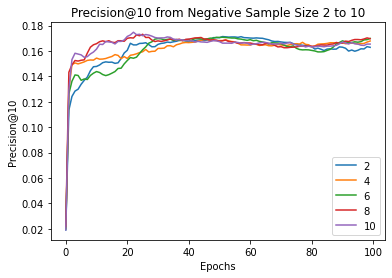

In [27]:
for i in range(2, 11,2):
    plt.plot(log[i-2][1], label=str(i))
# plt.plot(log[9][1], label=str(12))
# 添加图例
plt.legend()

# 添加图表标题和轴标签
plt.title('Precision@10 from Negative Sample Size 2 to 10')
plt.xlabel('Epochs')
plt.ylabel('Precision@10')

# 显示图表
plt.show()

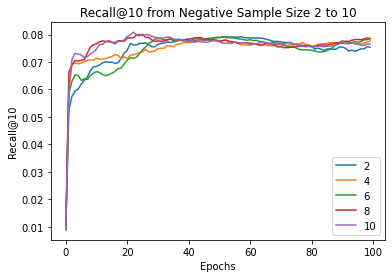

In [28]:
for i in range(2, 11,2):
    plt.plot(log[i-2][2], label=str(i))
# plt.plot(log[9][2], label=str(12))
# 添加图例
plt.legend()

# 添加图表标题和轴标签
plt.title('Recall@10 from Negative Sample Size 2 to 10')
plt.xlabel('Epochs')
plt.ylabel('Recall@10')

# 显示图表
plt.show()

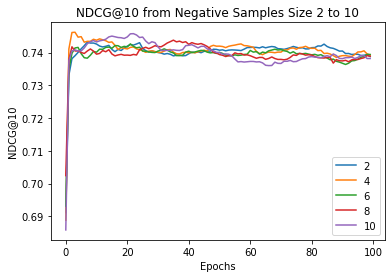

In [29]:
for i in range(2, 11,2):
    plt.plot(log[i-2][3], label=str(i))
# plt.plot(log[9][3], label=str(12))
# 添加图例
plt.legend()

# 添加图表标题和轴标签
plt.title('NDCG@10 from Negative Samples Size 2 to 10')
plt.xlabel('Epochs')
plt.ylabel('NDCG@10')

# 显示图表
plt.show()

In [39]:
st = np.array(log[8])

In [45]:
st = st[1:, :]
st.shape

(3, 100)

In [47]:
np.max(st, axis=1)


array([0.1747614 , 0.08085962, 0.74575626])

### 1M

In [48]:
model2 = BPR()
model2.preprocess(df2)

In [49]:
%%time
model2.fit( k = 50, max_iter = 100, stepsize=0.01, ite=10)

Train | 1/100, BPR loss: 34.657359375
Valid | 1/100, Pre@10: 0.033294701986754965, Recl@10: 0.009933267803073336, NDCG@10: 0.6960358252141375
---------------------------------------------------
Train | 2/100, BPR loss: 34.6560875
Valid | 2/100, Pre@10: 0.0746523178807947, Recl@10: 0.022272055954280296, NDCG@10: 0.7251950244662749
---------------------------------------------------
Train | 3/100, BPR loss: 34.65270625
Valid | 3/100, Pre@10: 0.09973509933774835, Recl@10: 0.029755348207714458, NDCG@10: 0.7353842955619319
---------------------------------------------------
Train | 4/100, BPR loss: 34.64605625
Valid | 4/100, Pre@10: 0.10220198675496689, Recl@10: 0.030491328765973002, NDCG@10: 0.7385610497709792
---------------------------------------------------
Train | 5/100, BPR loss: 34.636359375
Valid | 5/100, Pre@10: 0.10460264900662251, Recl@10: 0.031207551456895744, NDCG@10: 0.7403312869354471
---------------------------------------------------
Train | 6/100, BPR loss: 34.6228625
Val

Train | 44/100, BPR loss: 30.569125
Valid | 44/100, Pre@10: 0.15892384105960264, Recl@10: 0.04741394213908551, NDCG@10: 0.753129139754284
---------------------------------------------------
Train | 45/100, BPR loss: 30.415171875
Valid | 45/100, Pre@10: 0.15956953642384106, Recl@10: 0.04760658134560956, NDCG@10: 0.7532760290209777
---------------------------------------------------
Train | 46/100, BPR loss: 30.18348125
Valid | 46/100, Pre@10: 0.16054635761589403, Recl@10: 0.0478980098888126, NDCG@10: 0.7534325701057242
---------------------------------------------------
Train | 47/100, BPR loss: 29.982515625
Valid | 47/100, Pre@10: 0.1612913907284768, Recl@10: 0.04812028589634035, NDCG@10: 0.7539057418026662
---------------------------------------------------
Train | 48/100, BPR loss: 29.80809375
Valid | 48/100, Pre@10: 0.16240066225165564, Recl@10: 0.048451230174214995, NDCG@10: 0.7540347138415797
---------------------------------------------------
Train | 49/100, BPR loss: 29.50436875

Train | 87/100, BPR loss: 22.6162265625
Valid | 87/100, Pre@10: 0.16405629139072847, Recl@10: 0.04894517685760999, NDCG@10: 0.7509868084872927
---------------------------------------------------
Train | 88/100, BPR loss: 22.281384375
Valid | 88/100, Pre@10: 0.16443708609271523, Recl@10: 0.049058784594790836, NDCG@10: 0.751518525621033
---------------------------------------------------
Train | 89/100, BPR loss: 22.26685625
Valid | 89/100, Pre@10: 0.16438741721854305, Recl@10: 0.04904396619428899, NDCG@10: 0.7515873831284545
---------------------------------------------------
Train | 90/100, BPR loss: 22.332940625
Valid | 90/100, Pre@10: 0.16422185430463576, Recl@10: 0.048994571525949486, NDCG@10: 0.7512400639089014
---------------------------------------------------
Train | 91/100, BPR loss: 21.9870984375
Valid | 91/100, Pre@10: 0.16355960264900662, Recl@10: 0.04879699285259149, NDCG@10: 0.751202184201956
---------------------------------------------------
Train | 92/100, BPR loss: 21.